In [1]:
import pytesseract
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [13]:
img = cv2.imread('../images/agua/flat/IMG_20210322_101043130.jpg', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../images/agua/flat/IMG_20210322_100849338.jpg', cv2.IMREAD_GRAYSCALE)

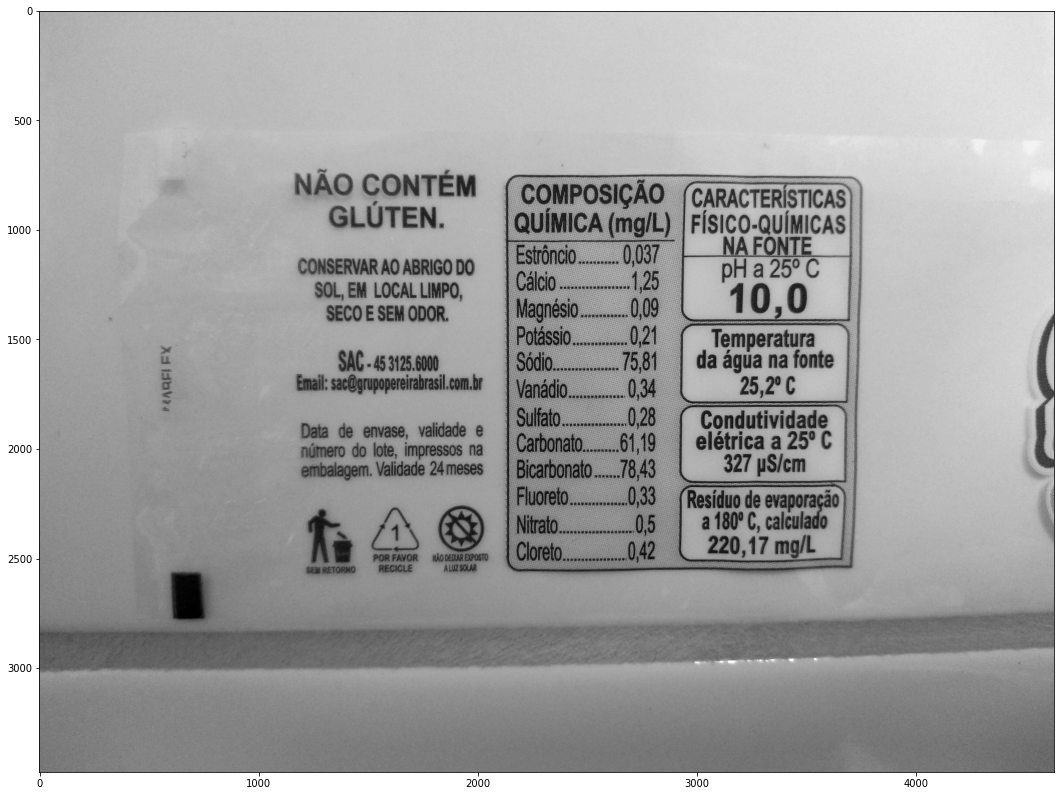

In [14]:
plt.figure(figsize=(220,14))
plt.imshow(img, cmap='gray')

In [15]:
mser = cv2.MSER_create()
regions, bounding_boxes = mser.detectRegions(img)

In [16]:
def calculate_rectangle_coordinates(bounding_box):
    x, y, w, h = bounding_box
    xmax = x + w
    ymax = y + h
    xmin = x
    ymin = y
    return ((xmax, ymax), (xmin, ymin))
    

In [17]:
def calculate_iou(bb_1, bb_2):
    (xmax_1, ymax_1), (xmin_1, ymin_1) = calculate_rectangle_coordinates(bb_1)
    (xmax_2, ymax_2), (xmin_2, ymin_2) = calculate_rectangle_coordinates(bb_2)
    
    x_left = max(xmin_1, xmin_2)
    y_top = max(ymin_1, ymin_2)
    x_right = min(xmax_1, xmax_2)
    y_bottom = min(ymax_1, ymax_2)

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    if x_right < x_left or y_bottom < y_top:
        return 0
    
    bb1_area = (xmax_1 - xmin_1) * (ymax_1 - ymin_1)
    bb2_area = (xmax_2 - xmin_2) * (ymax_2 - ymin_2)

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    return iou

In [18]:
def filter_bounding_boxes(bounding_boxes, threshold=0.9):
    filtered_bb = [bounding_boxes[0]]
    for bb in bounding_boxes[1:]:
        iou = calculate_iou(filtered_bb[-1], bb)
        if iou >= threshold:
            filtered_bb.pop()
        
        filtered_bb.append(bb)

    return filtered_bb

In [19]:
def draw_bounding_boxes(image, bounding_boxes):
    vis = image.copy()
    vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    for bb in bounding_boxes:
        (xmax, ymax), (xmin, ymin) = calculate_rectangle_coordinates(bb)
        cv2.rectangle(vis, (int(xmin), int(ymax)), (int(xmax), int(ymin)), (255, 255, 0), 2)
    return vis

In [20]:
def resize_bouding_boxes(bounding_boxes, amount):
    resized = []
    for bb in bounding_boxes:
        (xmax, ymax), (xmin, ymin) = calculate_rectangle_coordinates(bb)
        xmin = int((1 - amount) * xmin)
        ymin = int((1 - amount) * ymin)
        xmax = int((1 + amount) * xmax)
        ymax = int((1 + amount) * ymax)
        resized.append([xmin, ymin, xmax - xmin, ymax - ymin])
    return resized


In [21]:
def merge_boxes(bounding_boxes, threshold=10, amount=0.2, pixels_to_add=30):
    result = []
    idx_list = []

    for idx_current, bb_current in enumerate(bounding_boxes):
        
        if idx_current not in idx_list:
            (xmax_1, ymax_1), (xmin_1, ymin_1) = calculate_rectangle_coordinates(bb_current)
            idx_list.append(idx_current)
            width = xmax_1 - xmin_1
            xmax_1 += min(width * amount, pixels_to_add)
#             print(f"CURRENT=max({(xmax_1, ymax_1)}), min({(xmin_1, ymin_1)})")
            for idx_candidate, bb_candidate in enumerate(bounding_boxes[idx_current + 1:]):
                (xmax_2, ymax_2), (xmin_2, ymin_2) = calculate_rectangle_coordinates(bb_candidate)

                width = xmax_2 - xmin_2
                xmin_2 -= min(width * amount, pixels_to_add)
                xmax_2 += min(width * amount, pixels_to_add)
                
                
                x_left = max(xmin_1, xmin_2)
                y_top = max(ymin_1, ymin_2)
                x_right = min(xmax_1, xmax_2)
                y_bottom = min(ymax_1, ymax_2)
                
                
                intersection_area = (x_right - x_left) * (y_bottom - y_top)
                if x_right < x_left or y_bottom < y_top:
                    intersection_area = 0
                
#                 print(f"CANDIDATE=max({(xmax_2, ymax_2)}), min({(xmin_2, ymin_2)})")
                if intersection_area > threshold:
                    xmax_1 = max(xmax_1, xmax_2)
                    xmin_1 = min(xmin_1, xmin_2)
                    ymin_1 = min(ymin_1, ymin_2)
                    ymax_1 = max(ymax_1, ymax_2)
                    idx_list.append(idx_current + 1 + idx_candidate)
#                     print(f"UPDATED=max({(xmax_1, ymax_1)}), min({(xmin_1, ymin_1)}), AREA={intersection_area}")
                else:
                    break

            
            result.append([xmin_1, ymin_1, xmax_1 - xmin_1, ymax_1 - ymin_1])
#             print(f"LEN={len(result)}, NEW=max({(xmax_1, ymax_1)}), min({(xmin_1, ymin_1)}), w={xmax_1 - xmin_1}, h={ymax_1 - ymin_1}")
#             print("-----------------------------")

    return result
        

In [22]:
filtered = filter_bounding_boxes(bounding_boxes, threshold=0.7)
print(f"BEFORE={len(bounding_boxes)}, AFTER={len(filtered)}")

BEFORE=11741, AFTER=1508


In [23]:
merged = merge_boxes(filtered, threshold=0, pixels_to_add=100)
len(merged)
# merged_filter = filter_bounding_boxes(merged, threshold=0.7)

508

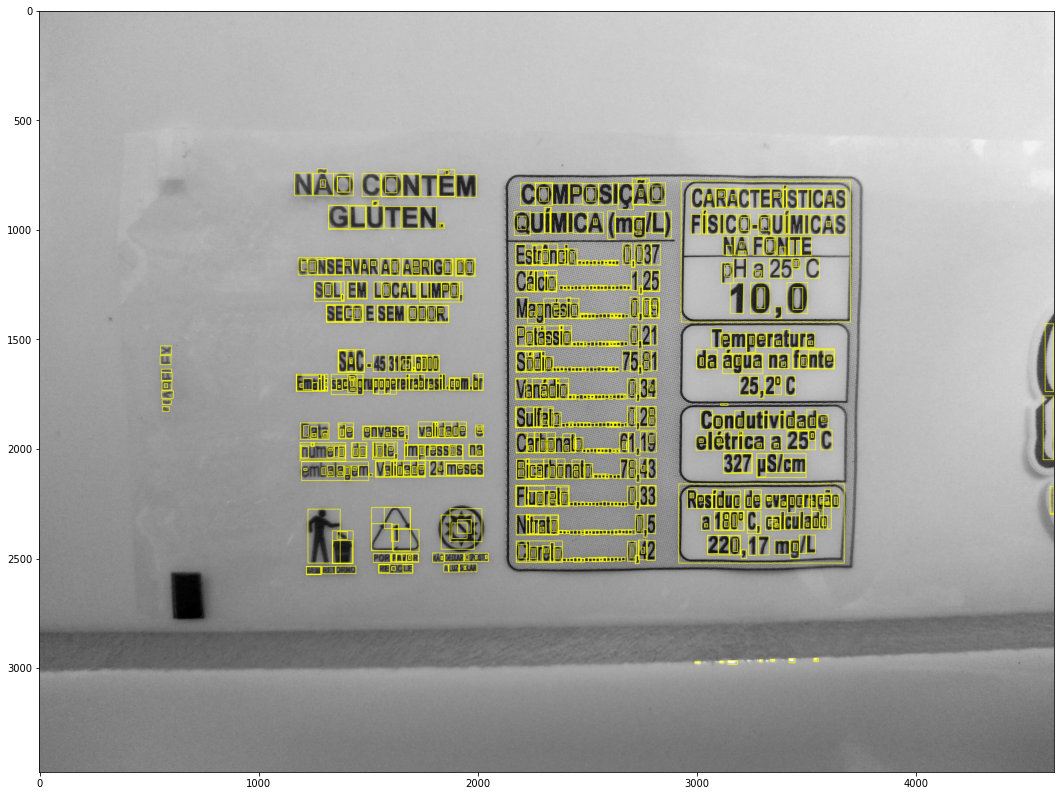

In [24]:
vis = draw_bounding_boxes(img, filtered)
plt.figure(figsize=(220,14))
plt.imshow(vis, cmap='gray')

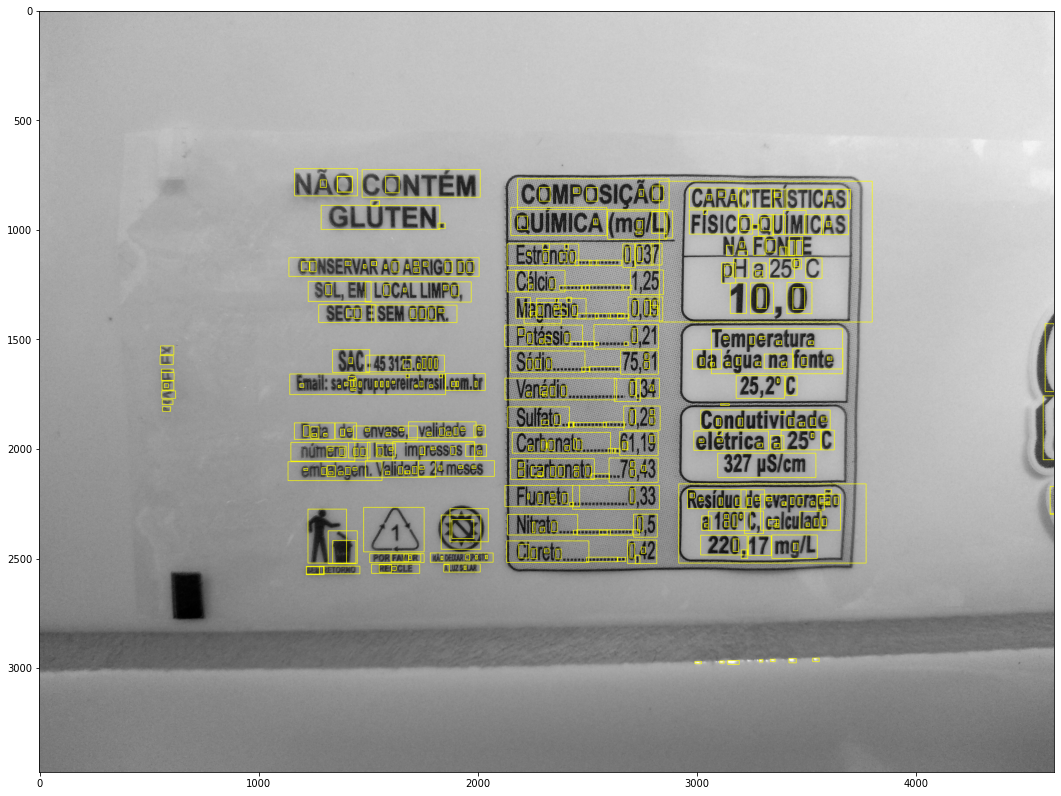

In [25]:
vis = draw_bounding_boxes(img, merged)
plt.figure(figsize=(220,14))
plt.imshow(vis, cmap='gray')
plt.savefig('foo.png')

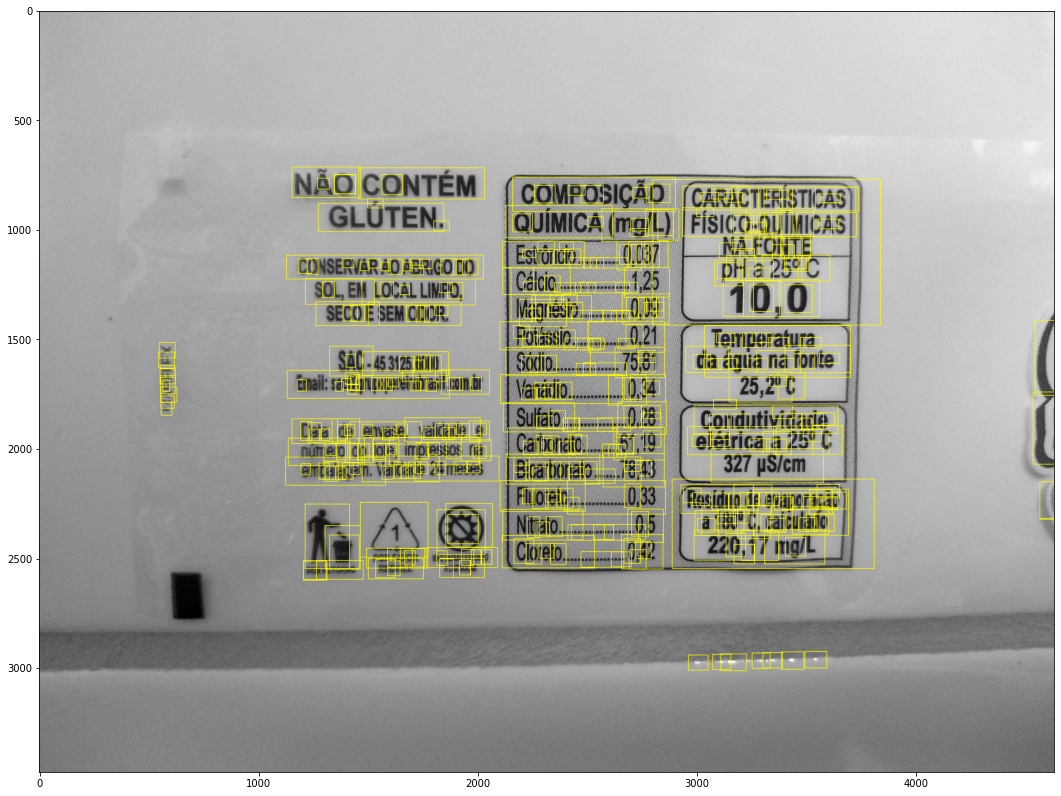

In [26]:
resized = resize_bouding_boxes(merged, 0.01)
vis = draw_bounding_boxes(img, resized)
plt.figure(figsize=(220,14))
plt.imshow(vis, cmap='gray')

In [105]:
def apply_ocr(image, bounding_boxes):
    results = []
    y, x = image.shape
    for idx, bb in enumerate(bounding_boxes):
#         if idx % 50 == 0:
#             print(f"NOW IN {idx}... {len(bounding_boxes) - idx} LEFT")
        (xmax, ymax), (xmin, ymin) = calculate_rectangle_coordinates(bb)
        ymin = max(0, int(ymin))
        ymax = min(y, int(ymax))
        xmin = max(0, int(xmin))
        xmax = min(x, int(xmax))
#         print(x, y, (xmax, ymax), (xmin, ymin))
        output = pytesseract.image_to_string(image[int(ymin):int(ymax), int(xmin):int(xmax)], lang='por')
        if output not in ['\x0c', '\n\x0c', ' \x0c', ' \n\x0c']:
            results.append((idx, output))
    
    return results

In [28]:
a = apply_ocr(img, resized)

NOW IN 0... 508 LEFT
NOW IN 50... 458 LEFT
NOW IN 100... 408 LEFT
NOW IN 150... 358 LEFT
NOW IN 200... 308 LEFT
NOW IN 250... 258 LEFT
NOW IN 300... 208 LEFT
NOW IN 350... 158 LEFT
NOW IN 400... 108 LEFT
NOW IN 450... 58 LEFT
NOW IN 500... 8 LEFT


In [29]:
a[5]

(5, ' \n\x0c')

In [30]:
for k, v in a:
    if v not in ['\x0c', '\n\x0c', ' \x0c', ' \n\x0c']:
        print(f"FOR {k}...")
        print(v)
        print("-------------")

FOR 7...
T W$A TPEN MSA

-------------
FOR 12...
nladaceniadoad dc dendhd

ALUZSOLAR

-------------
FOR 16...
embalagem. V

-------------
FOR 21...
n. Validade 2

-------------
FOR 22...
, umpressos n

-------------
FOR 23...
lote,

-------------
FOR 24...
 lote, lmpressos n

TU 9 D RR A TDA

-------------
FOR 25...
le 24 meses

-------------
FOR 26...
: envase,

-------------
FOR 28...
P

-------------
FOR 29...
k.l

-------------
FOR 30...
A

-------------
FOR 31...
A

-------------
FOR 32...
j

-------------
FOR 34...
Resíduo de evapora ão)
a 180º C, calcul
220,_7. _mglL

      
   

-------------
FOR 35...
D

    
   

  

(CARACTERÍSTICAS) |
) IFÍSICO-QUÍMICAS | |
| — NAFONTE

| pHa25C |
| 190 |

 

-------------
FOR 36...
| Cloreto.......

-------------
FOR 37...
AUCONSABARAI

-------------
FOR 39...
.nmt

-------------
FOR 40...
V

-------------
FOR 44...
PN aunh

-------------
FOR 46...
ng'q'éqguu'uuiujnél-l

-------------
FOR 49...
1 au

-------------
FO

In [65]:
def do_all(img):
    mser = cv2.MSER_create()
    regions, bounding_boxes = mser.detectRegions(img)
    filtered = filter_bounding_boxes(bounding_boxes, threshold=0.7)
    merged = merge_boxes(filtered, threshold=0, pixels_to_add=100)
    print(f"ORIGINAL={len(bounding_boxes)}, FILTERED={len(filtered)}, MERGED={len(merged)}")
    resized = resize_bouding_boxes(merged, 0.01)
    results = []
    try:
        if len(merged) < 10:
            print(f"Doing only for filtered")
            results.append(apply_ocr(img, filtered))
            return results
        else:
            try:
                print(f"Doing for merged!")
                results.append(apply_ocr(img, merged))
                return results
            except:
                return results
    except:
        return results
        
    


### Applying ocr to all data:

In [66]:
results = {}
for filename in sorted(glob.glob("../images/agua/flat/a/*")):
    print(filename)
#     break
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    texts = do_all(img)
    results[filename] = texts

../images/agua/flat/a/Screenshot_20210327_092316.png
ORIGINAL=2012, FILTERED=384, MERGED=1
Doing only for filtered
../images/agua/flat/a/Screenshot_20210327_092408.png
ORIGINAL=474, FILTERED=126, MERGED=60
Doing for merged!
../images/agua/flat/a/Screenshot_20210327_092544.png
ORIGINAL=1026, FILTERED=243, MERGED=88
Doing for merged!
../images/agua/flat/a/Screenshot_20210327_093801.png
ORIGINAL=5662, FILTERED=997, MERGED=276
Doing for merged!
../images/agua/flat/a/Screenshot_20210327_093820.png
ORIGINAL=1984, FILTERED=357, MERGED=1
Doing only for filtered
../images/agua/flat/a/Screenshot_20210327_093907.png
ORIGINAL=2636, FILTERED=509, MERGED=152
Doing for merged!
../images/agua/flat/a/Screenshot_20210327_093935.png
ORIGINAL=4355, FILTERED=1195, MERGED=353
Doing for merged!
../images/agua/flat/a/Screenshot_20210327_093954.png
ORIGINAL=3936, FILTERED=720, MERGED=259
Doing for merged!
../images/agua/flat/a/Screenshot_20210327_094011.png
ORIGINAL=1663, FILTERED=356, MERGED=128
Doing for mer

In [88]:
for t in results['../images/agua/flat/a/Screenshot_20210327_094053.png'][0]:
    print(t[1])


IndexError: list index out of range

In [75]:
results['../images/agua/flat/a/Screenshot_20210327_092408.png']

[]

In [90]:
img = cv2.imread('../images/agua/flat/a/Screenshot_20210327_094011.png', cv2.IMREAD_GRAYSCALE)
mser = cv2.MSER_create()
regions, bounding_boxes = mser.detectRegions(img)
filtered = filter_bounding_boxes(bounding_boxes, threshold=0.7)
merged = merge_boxes(filtered, threshold=0, pixels_to_add=100)
print(f"ORIGINAL={len(bounding_boxes)}, FILTERED={len(filtered)}, MERGED={len(merged)}")
resized = resize_bouding_boxes(merged, 0.01)

ORIGINAL=1663, FILTERED=356, MERGED=128


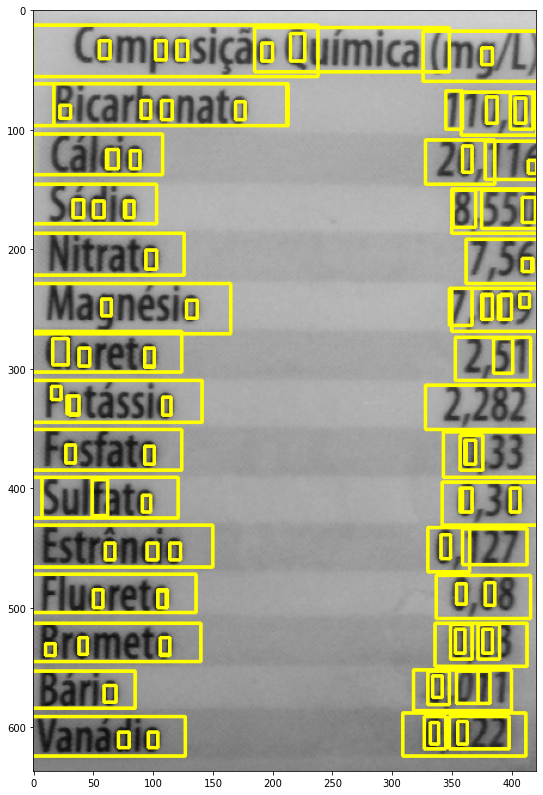

In [93]:
resized = resize_bouding_boxes(merged, 0.01)
vis = draw_bounding_boxes(img, merged)
plt.figure(figsize=(220,14))
plt.imshow(vis, cmap='gray')

In [106]:
a = apply_ocr(img, merged)

In [102]:
y, x = img.shape

In [107]:
a

[(0, 'Composição Q:\n\x0c'),
 (37, '/ /009\n\x0c'),
 (45, '8,550\n\x0c'),
 (87, '|\n\x0c'),
 (88, '[À\n\x0c')]

In [8]:
img = cv2.imread('doc_images/dog.jpg')
vis = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [11]:
vis.shape

(1776, 1080, 3)

In [24]:
vis[-1]

array([[132, 120,  98],
       [133, 121,  99],
       [133, 121,  99],
       ...,
       [121, 109,  87],
       [122, 110,  88],
       [122, 110,  88]], dtype=uint8)

In [22]:
vis

array([[[ 32,  42,  67],
        [ 30,  40,  65],
        [ 27,  37,  62],
        ...,
        [ 57,  55,  43],
        [ 51,  49,  37],
        [ 48,  46,  34]],

       [[ 31,  41,  66],
        [ 29,  39,  64],
        [ 27,  37,  62],
        ...,
        [ 53,  51,  39],
        [ 47,  45,  33],
        [ 43,  41,  29]],

       [[ 30,  40,  65],
        [ 28,  38,  63],
        [ 26,  36,  61],
        ...,
        [ 47,  47,  37],
        [ 41,  41,  31],
        [ 36,  36,  26]],

       ...,

       [[131, 119,  97],
        [132, 120,  98],
        [133, 121,  99],
        ...,
        [122, 110,  88],
        [123, 111,  89],
        [124, 112,  90]],

       [[131, 119,  97],
        [133, 121,  99],
        [133, 121,  99],
        ...,
        [121, 109,  87],
        [122, 110,  88],
        [123, 111,  89]],

       [[132, 120,  98],
        [133, 121,  99],
        [133, 121,  99],
        ...,
        [121, 109,  87],
        [122, 110,  88],
        [122, 110,  88]]